Первые 5 строк:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.0800

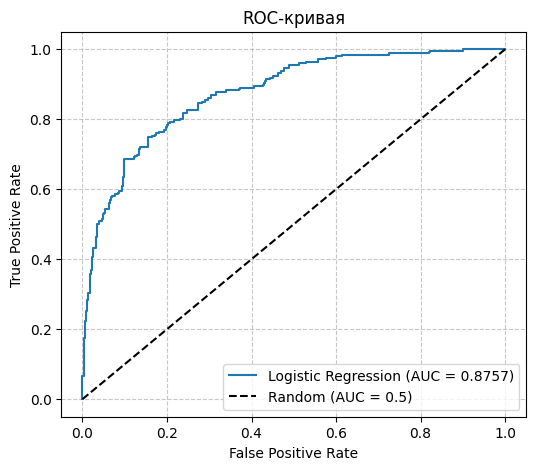

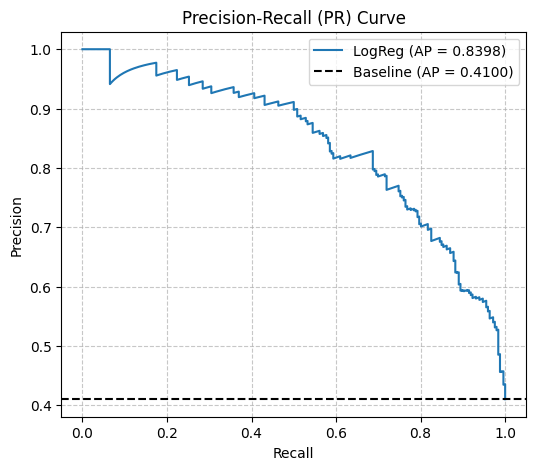


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       354
           1       0.79      0.69      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.78      0.79       600
weighted avg       0.80      0.80      0.80       600

           DummyClassifier  LogisticRegression
Метрика                                       
Accuracy              0.59              0.8000
ROC-AUC               0.50              0.8757
Precision             0.00              0.7944
Recall                0.00              0.6911
F1-score              0.00              0.7391


In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасета
df = pd.read_csv("S05-hw-dataset.csv")

# Выводим первый строки датасета
print("Первые 5 строк:")
print(df.head())

# Выводим информацию о столбцах и типах
print("\nИнформация о столбцах:")
df.info()

# Выводим базовые описательные статистики для числовых признаков
print("\nОписательные статистики:")
print(df.describe())

# Выводим распределение целевого признак
print("\nРаспределение целевого признака 'default':")
print(df['default'].value_counts(normalize=True))


# Зафиксируем наблюдения о датасете
# Количество объектов и признаков
n_objects, n_features = df.shape
print(f"Объектов: {n_objects}, Признаков: {n_features}")

numeric_cols = df.select_dtypes(include='number').columns
anomalies = {}
for col in numeric_cols:
    if (df[col] < 0).any():
        anomalies[col] = df[col].min()
if anomalies:
    print("Обнаружены потенциальные аномалии (отрицательные значения в колонках):", anomalies)
else:
    print("Явных аномалий (отрицательных значений в числовых колонках) не обнаружено.")


df['age_minus_employed'] = df['age'] - df['years_employed']
result = df[df['age_minus_employed'] <= 0]
print(result[['age', 'years_employed', 'age_minus_employed']])

target_counts = df['default'].value_counts().sort_index()
target_percent = df['default'].value_counts(normalize=True).sort_index() * 100

print("Распределение таргета (default):")
print(f"  0 (нет дефолта): {target_counts[0]} объектов ({target_percent[0]:.1f}%)")
print(f"  1 (дефолт):      {target_counts[1]} объектов ({target_percent[1]:.1f}%)")

# В датасете 3000 объектов и 17 признаков
# Есть столбец checking_balance в котором есть отрицательные записи (скорее всего означают долг клиента перед банком).
# Есть записи, в котороых стаж практически равен возрасту клиента и даже больше возраста (years_employed и age. 
# Например запись 2992: age 30, years_employed 35. Явно является ошибкой в датасете.
# Столбец default` является таргетом для предсказания. Доля клиентов с дефолтом составляет 41% (1231), без дефолта — 59% (1769). 
# Классы представлены достаточно сбалансированно для обучения модели. Однако в реальной жизни, такое количество клиентов с дефолтом заставляет задуматься о выборе клиентов банком



# Выделим таргет и удалим неинформативные/неиспользуемые столбцы
y = df['default']
X = df.drop(columns=['client_id', 'default']) 

# Проверим, что все признаки числовые
assert X.select_dtypes(include='number').shape[1] == X.shape[1], "В X есть нечисловые столбцы"

y = df['default']
X = df.drop(columns=['client_id', 'default'])

# Проверка: все признаки числовые
non_numeric = X.select_dtypes(exclude='number').columns.tolist()
assert len(non_numeric) == 0, f"Нечисловые столбцы: {non_numeric}"

# Проверка диапазонов по каждому признаку
def check_range(series, min_val=None, max_val=None, name=""):
    if min_val is not None:
        assert (series >= min_val).all(), f"В '{name}' есть значения < {min_val}"
    if max_val is not None:
        assert (series <= max_val).all(), f"В '{name}' есть значения > {max_val}"

# age: 21–69 лет
check_range(X['age'], min_val=21, max_val=69, name='age')

# income: 15 000–200 000
check_range(X['income'], min_val=15_000, max_val=200_000, name='income')

# years_employed: неотрицательное
check_range(X['years_employed'], min_val=0, name='years_employed')

# debt_to_income: [0, 1]
check_range(X['debt_to_income'], min_val=0.0, max_val=1.0, name='debt_to_income')

# num_credit_cards: обычно 0–7 (целое, неотрицательное)
check_range(X['num_credit_cards'], min_val=0, max_val=7, name='num_credit_cards')

# num_late_payments: ≥ 0 (целое)
check_range(X['num_late_payments'], min_val=0, name='num_late_payments')

# has_mortgage: бинарный (0 или 1)
unique_vals = X['has_mortgage'].unique()
assert set(unique_vals).issubset({0, 1}), f"has_mortgage содержит недопустимые значения: {unique_vals}"

# has_car_loan: бинарный (0 или 1)
unique_vals = X['has_car_loan'].unique()
assert set(unique_vals).issubset({0, 1}), f"has_car_loan содержит недопустимые значения: {unique_vals}"

# avings_balance: ≥ 0
check_range(X['savings_balance'], min_val=0, name='savings_balance')

# region_risk_score: [0, 1]
check_range(X['region_risk_score'], min_val=0.0, max_val=1.0, name='region_risk_score')

# phone_calls_to_support_last_3m: ≥ 0
check_range(X['phone_calls_to_support_last_3m'], min_val=0, name='phone_calls_to_support_last_3m')

# active_loans: ≥ 0 (целое)
check_range(X['active_loans'], min_val=0, name='active_loans')



# Разделим данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Создадим и обученим бейзлайн-модели
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

# Проведем оценку модели
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]  # вероятности класса 1

acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

# Выводим результаты 
print("Бейзлайн (DummyClassifier)")
print(f"Accuracy:  {acc_dummy:.4f}")
print(f"ROC-AUC:   {auc_dummy:.4f}")

# Бейзлайн-модель на основе `DummyClassifier` с `strategy="most_frequent"` показала на тестовой выборке: 
# Accuracy = 0.5900, ROC-AUC = 0.5000. 
# Эта модель всегда предсказывает наиболее частый класс, 
# в данном случае отсутствие дефолта (`default = 0`), поскольку он составляет около 59 % выборки. 
# Соответственно, её точность совпадает с долей этого класса, а ROC-AUC равен 0.5, что эквивалентно случайному угадыванию. 
# Несмотря на кажущуюся точность, модель не использует никакой информации о признаках и не способна отличать дефолтных клиентов от надежных. 
# Именно поэтому бейзлайн служит точкой отсчета, любая содержательная модель должна превосходить его как по ROC-AUC (стремясь к 1.0), 
# так и по другим метрикам, чтобы подтвердить, что она действительно извлекает полезные закономерности из данных, 
# а не просто повторяет статистику распределения классов.



# Импортируем дополнительные библиотеки
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, classification_report, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# Создание пайплайна
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Подбор параметра 'C' с помощью GridSearchCV
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l2'], 
    'logreg__solver': ['liblinear', 'saga']  
}

# Используем стратифицированную кросс-валидацию 
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)

# Обучение с подбором параметров
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC на кросс-валидации:", f"{grid_search.best_score_:.4f}")

# Оценка лучшей модели на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nМетрики лучшей модели на тестовой выборке")
print(f"Accuracy:  {acc:.4f}")
print(f"ROC-AUC:   {auc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nМатрица ошибок:")
print(cm)

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('figures/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Построение PR-кривой
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'LogReg (AP = {avg_precision:.4f})')
baseline = y_test.mean()
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (AP = {baseline:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('figures/pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Вывод подробного отчёта
print("\nClassification Report")
print(classification_report(y_test, y_pred))







# Сведем результаты в компактный вид
results = pd.DataFrame({
    'Метрика': ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-score'],
    'DummyClassifier': [acc_dummy, auc_dummy, 
                        precision_score(y_test, y_pred_dummy, zero_division=0),
                        recall_score(y_test, y_pred_dummy, zero_division=0),
                        f1_score(y_test, y_pred_dummy, zero_division=0)],
    'LogisticRegression': [acc, auc, prec, rec, f1]
}).set_index('Метрика')
print(results.round(4))


# Бейзлайн-модель (`DummyClassifier`), предсказывающая всегда самый частый класс (отсутствие дефолта), 
# достигает Accuracy = 0.59 и ROC-AUC = 0.50 (не лучше случайного угадывания), так как игнорирует все признаки. 
# В отличие от неё, логистическая регрессия демонстрирует значительно более высокое качество: 
# Accuracy выросла до 0.80, а ROC-AUC до 0.876.
# Модель показывает способность разделять классы более точно.    

# Среди разных вариантов регуляризации (параметр C) лучшей оказалась модель с C = 100.0, 
# то есть с минимальным штрафом за сложность. 
# Получается, что данные достаточно хорошие и информативные, и модель выигрывает, когда ей дают чуть больше гибкости, так как при более сильной регуляризации (C = 0.01–1.0) качество падало.

# В итоге, логистическая регрессия с слабой регуляризацией выглядит лучшим выбором. 
# Она сильно превосходит наивный бейзлайн, даёт сбалансированные Precision (0.79) и Recall (0.69), 
# легко интерпретируется и подходит для практического применения в кредитном скоринге.